In [1]:
import findspark
findspark.init('/opt/spark')
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("BDH-DATA-JOB") \
    .enableHiveSupport() \
    .getOrCreate()

print("Spark版本:", spark.version)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/03/07 09:03:43 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
Spark版本: 3.3.3


In [2]:
! pip install geopandas shapely

Defaulting to user installation because normal site-packages is not writeable


In [4]:
id = 1
sql = """
SELECT lon, lat
FROM (
	SELECT lon, lat
	FROM dwd_time_series as time_series
	WHERE EXISTS (
		SELECT *
		FROM job
		WHERE job.id = {id}
			AND time_series.time BETWEEN job.start_time AND job.end_time
	)
) time_series;
""".format(id=id)
points_df = spark.sql(sql)
print(points_df.count())
points_df.show()


AnalysisException: Table or view not found: job; line 8 pos 7;
'Project ['lon, 'lat]
+- 'SubqueryAlias time_series
   +- 'Project ['lon, 'lat]
      +- 'Filter exists#1 []
         :  +- 'Project [*]
         :     +- 'Filter (('job.id = 1) AND (('time_series.time >= 'job.start_time) AND ('time_series.time <= 'job.end_time)))
         :        +- 'UnresolvedRelation [job], [], false
         +- SubqueryAlias time_series
            +- SubqueryAlias spark_catalog.default.dwd_time_series
               +- Relation default.dwd_time_series[id#2L,time#3,lon#4,lat#5,yearMonth#6] parquet


1441


+---------+---------+
|      lon|      lat|
+---------+---------+
| 45.00023| 46.00023|
| 45.00023| 46.00023|
| 45.00023| 46.00023|
| 45.00023| 46.00023|
| 45.00023| 46.00023|
| 45.00023| 46.00023|
| 45.00023| 46.00023|
| 45.00023| 46.00023|
| 45.00023| 46.00023|
|45.000233|46.000233|
|45.000233|46.000233|
|45.000233|46.000233|
|45.000233|46.000233|
|45.000233|46.000233|
|45.000233|46.000233|
|45.000233|46.000233|
|45.000233|46.000233|
|45.000233|46.000233|
|45.000233|46.000233|
|45.000233|46.000233|
+---------+---------+
only showing top 20 rows



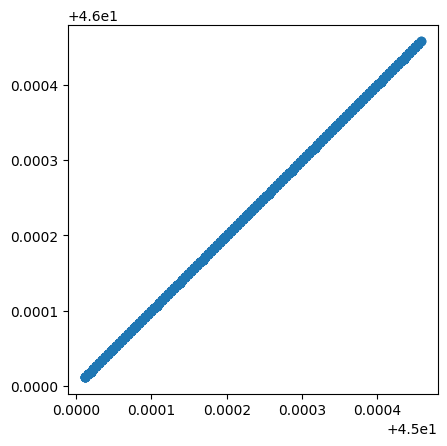

In [7]:
id = 1
sql = """
SELECT lon,lat
FROM (
	SELECT lon, lat
	FROM dwd_time_series as time_series
	WHERE EXISTS (
		SELECT *
		FROM dwm_job as job
		WHERE job.id = 1
			AND time_series.time BETWEEN job.start_time AND job.end_time
	)
) dwd_time_series;
"""
points_df = spark.sql(sql)
print(points_df.count())
points_df.show()

# https://ncar.github.io/PySpark4Climate/tutorials/pyspark-geo-analysis/geopandas-and-spark/#Load-Data-in-a-GeoDataFrame
# 创建GeoDataFrame

lon_list = points_df.select("lon").rdd.flatMap(lambda x: x).collect()
lat_list = points_df.select("lat").rdd.flatMap(lambda x: x).collect()
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import LineString
import matplotlib.pyplot as plt


# 创建几何对象
geometry = [Point(xy) for xy in zip(lon_list,lat_list)]

# 创建Geopandas的GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=geometry)

fig,ax=plt.subplots()

# 将 GeoDataFrame 转换为 GeoSeries 对象
geo=gdf['geometry']

# 使用 GeoSeries 对象绘制线条
gpd.GeoSeries(geometry).plot(ax=ax)

# 显示图形
plt.show()

# # 创建曲线
# gdf['curve'] =gdf['geometry'].apply(lambda geom: LineString(geom.coords))

# # 删除重复的曲线
# gdf = gdf.drop_duplicates(subset=['group_column', 'curve'])

# # 将GeoDataFrame的几何列转换为WKT格式的字符串
# gdf['curve_wkt'] = gdf['curve'].apply(lambda x: x.wkt)

# print(gdf['curve_wkt'])


In [8]:
from shapely.geometry import LineString

print(f"LineString contains {len(gdf['geometry'].tolist())} points.")
linestring = LineString(gdf['geometry'].tolist())


LineString contains 999947 points.


In [9]:
sql = """
INSERT INTO gisdb.output (job_id, geoms)
VALUES (1, ST_GeomFromText('{linestring}', 4326));
""".format(linestring=linestring)
print(sql)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

